<a href="https://colab.research.google.com/github/SinaRampe/Health-Topic-Classifier/blob/main/train_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task: Train a classifier that decides, whether a question is about a health care topic.

Install and import dependencies.

In [5]:
! pip install transformers
! pip install umap-learn==0.5.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datasets import load_dataset
import torch
import transformers
import pickle
from umap import UMAP
from sklearn.preprocessing import MinMaxScaler

In [10]:
!git clone https://github.com/SinaRampe/Health-Topic-Classifier.git

Cloning into 'Health-Topic-Classifier'...
remote: Enumerating objects: 15, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 15 (delta 2), reused 6 (delta 1), pack-reused 0
Unpacking objects: 100% (15/15), 144.09 KiB | 3.79 MiB/s, done.


In [20]:
!ls Health-Topic-Classifier/data

classifier_test.csv  classifier_train.csv  df_full.csv


### Load datasets.

In [25]:
train = pd.read_csv("Health-Topic-Classifier/data/classifier_train.csv")
test = pd.read_csv("Health-Topic-Classifier/data/classifier_test.csv")
full = pd.read_csv("Health-Topic-Classifier/data/df_full.csv")

### Tokenizer setup.

In [26]:
from transformers import AutoTokenizer

model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [32]:
def tokenize(batch):
    return tokenizer(batch["prompt"], padding=True, truncation=True)

In [33]:
train_encoded = train.map(tokenize, batched=True, batch_size=None)
test_encoded = test.map(tokenize, batched=True, batch_size=None)
full_encoded = full.map(tokenize, batched=True, batch_size=None)

AttributeError: ignored

## Training a Text Classifier.

#### Extract hidden states.

In [34]:
from transformers import AutoModel

model_ckpt = "distilbert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [35]:
def extract_hidden_states(batch):
    # Place model inputs on the GPU
    inputs = {k:v.to(device) for k,v in batch.items() 
              if k in tokenizer.model_input_names}
    # Extract last hidden states
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state
    # Return vector for [CLS] token
    return {"hidden_state": last_hidden_state[:,0].cpu().numpy()}

In [36]:
train_encoded.set_format("torch", 
                            columns=["input_ids", "attention_mask", "completion"])
test_encoded.set_format("torch", 
                            columns=["input_ids", "attention_mask", "completion"])
full_encoded.set_format("torch", 
                            columns=["input_ids", "attention_mask", "completion"])

NameError: ignored

In [ ]:
train_hidden = train_encoded.map(extract_hidden_states, batched=True)
test_hidden = test_encoded.map(extract_hidden_states, batched=True)
full_hidden = full_encoded.map(extract_hidden_states, batched=True)

  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/4 [00:00<?, ?ba/s]

In [ ]:
train_hidden["train"].column_names

['attention_mask', 'completion', 'hidden_state', 'input_ids', 'prompt']

#### Extract features and visualize the training set.

In [ ]:
X_train = np.array(train_hidden["train"]["hidden_state"])
X_valid = np.array(test_hidden["train"]["hidden_state"])
y_train = np.array(train_hidden["train"]["completion"])
y_valid = np.array(test_hidden["train"]["completion"])
X_full = np.array(full_hidden["train"]["hidden_state"])
y_full = np.array(full_hidden["train"]["completion"])
X_train.shape, X_valid.shape, X_full.shape

((2650, 768), (758, 768), (3787, 768))

For visualizing the hidden states (768 D) we project the vectors down to 2D with UMAP after applying MinMaxScaler.

In [ ]:
scaler = MinMaxScaler()
umap = UMAP(n_components=2, metric="cosine")
# Scale features to [0,1] range
X_scaled = scaler.fit_transform(X_train)
# Initialize and fit UMAP
mapper = umap.fit(X_scaled)
# Create a DataFrame of 2D embeddings
df_emb = pd.DataFrame(mapper.embedding_, columns=["X", "Y"])
df_emb["label"] = y_train
df_emb.head()

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


,X,Y,label
0,6.926993,-0.812703,0
1,4.210525,3.683229,1
2,9.565412,0.862979,0
3,8.054652,2.320664,0
4,9.893273,1.262235,0


Plot the density. 

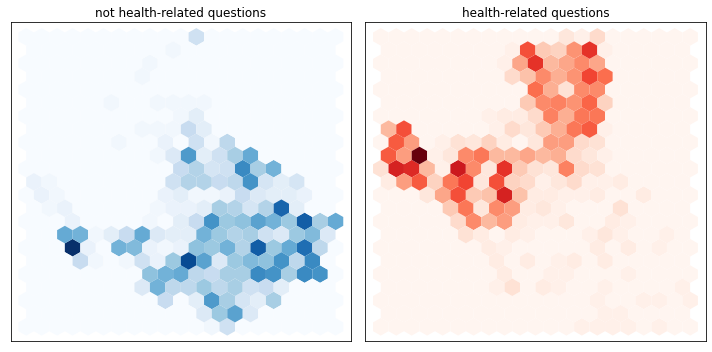

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10,5))
axes = axes.flatten()
cmaps = ["Blues", "Reds"]
labels = ["not health-related questions", "health-related questions"]

for i, (label, cmap) in enumerate(zip(labels, cmaps)):
    df_emb_sub = df_emb.query(f"label == {i}")
    axes[i].hexbin(df_emb_sub["X"], df_emb_sub["Y"], cmap=cmap,
                   gridsize=20, linewidths=(0,))
    axes[i].set_title(label)
    axes[i].set_xticks([]), axes[i].set_yticks([])

plt.tight_layout()
plt.show()

#### Train a simple classifier.


Use the hidden states to train a logistic regression model.

In [ ]:
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression(max_iter=5000)
#lr_clf.fit(X_train, y_train)
lr_clf.fit(X_full, y_full)

LogisticRegression(max_iter=5000)

In [ ]:
#lr_clf.score(X_valid, y_valid) -> was 0.98 on test, which is sufficient for our task

Lets look at one example:

In [ ]:
print("Question: ", full_hidden["train"]["prompt"][32])
print("Prediction: ", lr_clf.predict(np.array(full_hidden["train"]["hidden_state"][32]).reshape(1, -1))[0])

Question:  Zener diodes below what voltage are not widely available?
Prediction:  0


#### Lets classify an invented question.

In [ ]:
text = "What is Ibuprofen?"
inputs = tokenizer(text, return_tensors="pt")
print(f"Input tensor shape: {inputs['input_ids'].size()}")

Input tensor shape: torch.Size([1, 9])


In [ ]:
print("Question: ", text)
print("Prediction: ",lr_clf.predict(extract_hidden_states(inputs)["hidden_state"])[0])

Question:  What is Ibuprofen?
Prediction:  1


### Further investigations of the performance

####Confusion matrix.

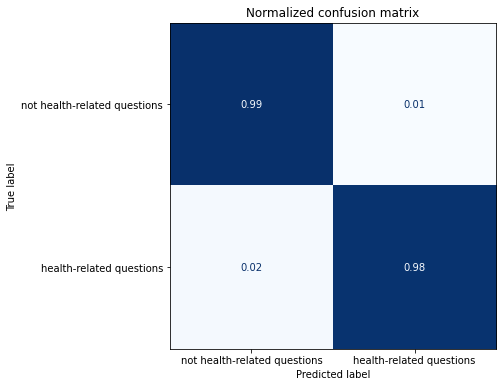

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()
    
y_preds = lr_clf.predict(X_valid)
plot_confusion_matrix(y_preds, y_valid, labels)

#### Let's take a look at the false predictions. -> Not too bad!

In [ ]:
classification_is_wrong = lr_clf.predict(X_valid) != y_valid
indizes = [i for i, x in enumerate(classification_is_wrong) if x]

In [ ]:
test["train"][indizes]

{'completion': [1, 1, 1, 0, 1, 1, 1, 0, 1],
 'prompt': ['Drugs made between which years had to be tested before going to market?',
  'What is the definition of the common cold?',
  'what does a score f 100 in the rumination subscale mean?',
  'Does physical aggression decline or increase during high-school, college, and early adulthood?',
  'why do hearts flutter?',
  'What is guided imagery?',
  'where can i find a table that converts inr alues to quick test values?',
  'What is the effect of caffeine?',
  'What are the advantages of silver fillings?']}

#### Dump the trained classifier.

In [ ]:
pickle.dump(lr_clf, open("log_regr_classifier.sav", 'wb'))